In [1]:
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from tempfile import TemporaryFile
import os
import math
import pickle
import random
import operator

In [2]:

def getNeighbors(trainingset, instance, k):
    distances = []
    for x in range(len(trainingset)):
        dist = distance(trainingset[x], instance, k) + distance(instance,trainingset[x],k)
        distances.append((trainingset[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [3]:
#function to identify the nearest neighbors

def nearestclass(neighbors):
    classVote = {}
    
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1
            
    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [4]:
# fuction for model evaluation

def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == prediction[x]:
            correct += 1
    return 1.0 * correct / len(testSet)

In [6]:
from scipy.fftpack import dct


directory = 'C:/Users/fanis/Downloads/Big Data/archive/Data/genres_original'

# High frequencies are amplified.
def pre_emphasis(signal, pre_emph_coeff=0.97):
    return np.append(signal[0], signal[1:] - pre_emph_coeff * signal[:-1])

# The signal is divided into short frames.
def framing(signal, sample_rate, frame_size=0.025, frame_stride=0.01):
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z)
    
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

# A Hamming window is applied to each frame. 
# Window function used in signal processing to reduce spectral leakage when performing Fourier transforms.
def windowing(frames):
    return frames * np.hamming(frames.shape[1])

# FFT is computed for each frame
def fft(frames, NFFT=512):
    return np.fft.rfft(frames, NFFT)

def power_spectrum(frames, NFFT=512):
    return (1.0 / NFFT) * ((frames) ** 2)

# The frequency spectrum is filtered using Mel filters.
def mel_filter_bank(sample_rate, NFFT=512, nfilt=40):
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)
    
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    
    return fbank


"""
The logarithm of the Mel-filtered spectrum is computed.
The purpose of the Mel filter bank is to mimic the human ear's response 
to different frequencies, emphasizing frequencies that are more perceptually important
""" 

def log_mel_spectrum(frames, fbank):
    mel_spectrum = np.dot(frames, fbank.T)
    mel_spectrum = np.where(mel_spectrum == 0, np.finfo(float).eps, mel_spectrum)
    return np.log(mel_spectrum)

# The DCT is applied to obtain the MFCCs.
def dct_transform(log_mel_spectrum, num_ceps=12):
    return dct(log_mel_spectrum, type=2, axis=1, norm='ortho')[:, :num_ceps]

def compute_mfcc(signal, sample_rate):
    emphasized_signal = pre_emphasis(signal)
    frames = framing(emphasized_signal, sample_rate)
    windowed_frames = windowing(frames)
    fft_frames = fft(windowed_frames)
    power_frames = power_spectrum(np.abs(fft_frames))
    fbank = mel_filter_bank(sample_rate)
    log_mel = log_mel_spectrum(power_frames, fbank)
    mfccs = dct_transform(log_mel)
    return mfccs

# Open a binary file to save the dataset
with open("mydataset.dat", "wb") as f:
    genre_index = 0  # Initialize genre index
    # Iterate over each folder in the directory
    for genre_folder in os.listdir(directory):
        genre_index += 1
        if genre_index == 11:
            break  # Limit to 10 genres
        
        genre_path = os.path.join(directory, genre_folder)
        # Iterate over each file in the genre folder
        for audio_file in os.listdir(genre_path):
            file_path = os.path.join(genre_path, audio_file)
            try:
                # Read the audio file
                rate, sig = wav.read(file_path)
                
                # Extract MFCC features
                mfcc_feat = compute_mfcc(sig, rate)
                covariance = np.cov(np.matrix.transpose(mfcc_feat))
                mean_matrix = mfcc_feat.mean(axis=0)
                
                # Create a feature tuple (mean, covariance, genre index)
                feature = (mean_matrix, covariance, genre_index)
                
                # Save the feature using pickle
                pickle.dump(feature, f)
            
            except ValueError as e:
                print(f"Skipping file {file_path}: {e}")
            except Exception as e:
                print(f"Got an exception: {e} in folder: {genre_folder} filename: {audio_file}")
f.close()


Skipping file C:/Users/fanis/Downloads/Big Data/archive/Data/genres_original\jazz\jazz.00054.wav: File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF' and 'RIFX' supported.


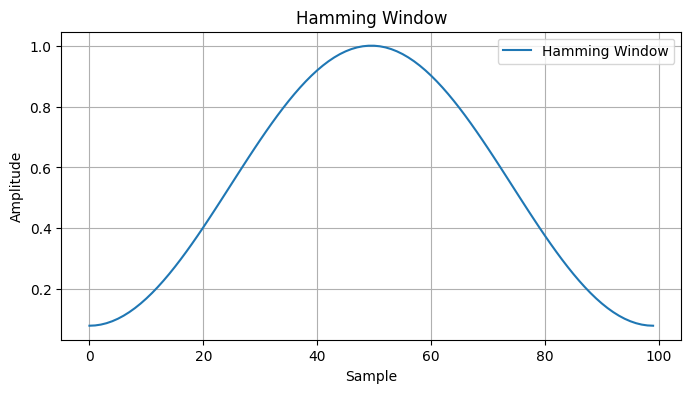

In [10]:
# Example of Hamming Window

import numpy as np
import matplotlib.pyplot as plt

# Define the number of samples
N = 100

# Generate the Hamming window
hamming_window = np.hamming(N)

# Plot the Hamming window
plt.figure(figsize=(8, 4))
plt.plot(hamming_window, label='Hamming Window')
plt.title('Hamming Window')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


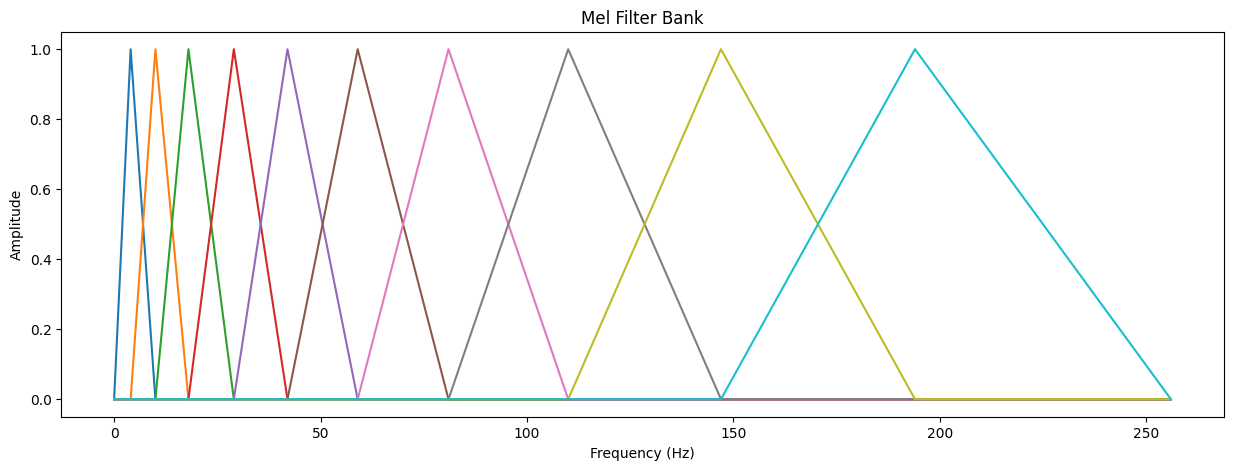

In [11]:
# Example of Mel Filter Bank

from scipy.fftpack import fft
from scipy.fftpack import dct

def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

def get_filter_points(fmin, fmax, mel_filter_num, nfft, sample_rate):
    fmin_mel = hz_to_mel(fmin)
    fmax_mel = hz_to_mel(fmax)
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num + 2)
    freqs = mel_to_hz(mels)
    return np.floor((nfft + 1) / sample_rate * freqs).astype(int)

def get_filters(filter_points, nfft):
    filters = np.zeros((len(filter_points) - 2, nfft // 2 + 1))
    for n in range(1, len(filter_points) - 1):
        filters[n - 1, filter_points[n - 1]: filter_points[n]] = \
            (np.arange(filter_points[n - 1], filter_points[n]) - filter_points[n - 1]) / (filter_points[n] - filter_points[n - 1])
        filters[n - 1, filter_points[n]: filter_points[n + 1]] = \
            (filter_points[n + 1] - np.arange(filter_points[n], filter_points[n + 1])) / (filter_points[n + 1] - filter_points[n])
    return filters

# Parameters
sample_rate = 22050
nfft = 512
fmin = 0
fmax = sample_rate / 2
mel_filter_num = 10

filter_points = get_filter_points(fmin, fmax, mel_filter_num, nfft, sample_rate)
filters = get_filters(filter_points, nfft)

# Plot the Mel filter bank
plt.figure(figsize=(15, 5))
for i in range(filters.shape[0]):
    plt.plot(filters[i])
plt.title('Mel Filter Bank')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()


In [7]:
dataset = []

def loadDataset(filename, split, trset, teset):
    with open('mydataset.dat','rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trset.append(dataset[x])
        else:
            teset.append(dataset[x])

trainingSet = []
testSet = []
loadDataset('mydataset.dat', 0.68, trainingSet, testSet)

In [8]:
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

In [9]:
# Make the prediction using KNN(K nearest Neighbors)
length = len(testSet)
predictions = []
for x in range(length):
    predictions.append(nearestclass(getNeighbors(trainingSet, testSet[x], 5)))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1)

0.6687898089171974
